# Introduction
## So far we have preprocessed the given news articles and corresponding labels and made them ready to perform modelling on them. In this notebook we will be performing modelling on the news articles using the following algorithms:
### - Naive bayes
### - Logistic regression
### - Linear SVM
### - Multilayer perceptron
### - LSTM - with ngram collocation and using pretrained wordembedding
### - CNN - - with ngram collocation and using pretrained wordembedding
### - CNN + LSTM -  with ngram collocation and using pretrained wordembedding
### - FastText 
======================================================================================================================

In [1]:
# importing libraries
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.naive_bayes import MultinomialNB
import numpy as np
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation,GlobalAveragePooling1D
from keras.callbacks import  EarlyStopping
import re
from fastText import train_supervised

### Loading the cleaned data

In [2]:
def read_data(filepath):
    temp_data = open(filepath,'r')
    temp_data = temp_data.readlines()
    temp_data = [x.replace('\n','') for x in  temp_data]
    return temp_data

def read_label(filepath):
    temp_pd  = pd.read_csv(filepath)
    temp_pd = temp_pd.y.str.replace('C','')
    return list(temp_pd.values)

In [3]:
train_data_ngram = read_data('../Data/processed/train_data1.txt')
train_data_no_ngram = read_data('../Data/processed/train_data_no_ngram.txt')
val_data_ngram = read_data('../Data/processed/validation_data1.txt')
val_data_no_ngram = read_data('../Data/processed/validation_data_no_ngram.txt')
complete_data_ngram = read_data('../Data/processed/complete_data1.txt')
complete_data_no_ngram = read_data ('../Data/processed/complete_data_no_ngram.txt')
train_label_ngram = read_label('../Data/processed/train_labels1.csv')
train_label_no_ngram = read_label('../Data/processed/train_labels_no_ngram.csv')
val_label_ngram = read_label('../Data/processed/validation_labels1.csv')
val_label_no_ngram  = read_label('../Data/processed/validation_labels_no_ngram.csv')
test_labels = open('../Data/original/testing_labels.txt','r').readlines()
test_labels = pd.DataFrame(test_labels).loc[:,0].str.extract('.+C(\d+)\n')
test_data_ngram = read_data('../Data/processed/test_data1.txt')
test_data_no_ngram = read_data('../Data/processed/test_data_no_ngram.txt')
complete_labels_ngram =  train_label_ngram + val_label_ngram
complete_labels_no_ngram = train_label_no_ngram + val_label_no_ngram

C:\Users\VM\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


In [4]:
# Creating dictionary to store different model performances
df_performances = {}

## Using TF IDF
### First we will create models using TF IDF form of the data and evaluate their performance on validation data


#### For ngram data

In [5]:
# learning the tfidf vectorizer to learn vocabulary and the id values of each word from training data
tfidf_vectorizer = TfidfVectorizer(input = 'content', analyzer = 'word')
tfidf_train_data_ngram = tfidf_vectorizer.fit_transform(complete_data_ngram)
# transforming test data into idf vector
tfidf_test_data_ngram = tfidf_vectorizer.transform(test_data_ngram) 

#### For data without ngrams

In [6]:
# learning the tfidf vectorizer to learn vocabulary and the id values of each word from training data
tfidf_vectorizer = TfidfVectorizer(input = 'content', analyzer = 'word')
tfidf_train_data_no_ngram = tfidf_vectorizer.fit_transform(complete_data_no_ngram)
# transforming test data into idf vector
tfidf_test_data_no_ngram = tfidf_vectorizer.transform(test_data_no_ngram) 

## Naive Bayes classifier
=================================
### 5 fold Crossvalidation performance

In [29]:
# Creating a stratified shuffled split
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=321)

In [30]:
clf_MNB = MultinomialNB(alpha = 0.1)
crossval_arr = cross_val_score(clf_MNB, tfidf_train_data_ngram, complete_labels_ngram, cv=sss)
avg_nb = sum(crossval_arr)/len(crossval_arr)

In [31]:
print ('NB 5 fold crossvalidation avg accuracy =  ',avg_nb)

NB 5 fold crossvalidation avg accuracy =   0.7528019164826907


### Performance on test dataset

In [32]:
clf_MNB = clf_MNB.fit(tfidf_train_data_ngram, complete_labels_ngram)
predicted_nb = clf_MNB.predict(tfidf_test_data_ngram)
nb_accu = accuracy_score (test_labels,predicted_nb)

In [33]:
nb_accu

0.7399098083427283

In [34]:
# Adding to performance dictionary
df_performances['NB_ngram'] = nb_accu

## SVM classifier
=======================
### 5 fold Crossvalidation performance

In [35]:
clf_svm= OneVsOneClassifier(SGDClassifier(loss='hinge', penalty='l2',alpha=1e-4, max_iter=50, random_state=42))

In [36]:
crossval_arr_svm = cross_val_score(clf_svm, tfidf_train_data_ngram, complete_labels_ngram, cv=sss)
avg_svm = sum(crossval_arr_svm)/len(crossval_arr_svm)
print ('SVM 5 fold crossvalidation avg accuracy =  ',avg_svm)

SVM 5 fold crossvalidation avg accuracy =   0.781708863732444


### Performance on test dataset

In [37]:
clf_svm = clf_svm.fit(tfidf_train_data_ngram, complete_labels_ngram)
predicted_svm = clf_svm.predict(tfidf_test_data_ngram)
svm_accu = accuracy_score (test_labels,predicted_svm)
svm_accu

0.7685080796692972

In [38]:
# Adding to performance dictionary
df_performances['SVM_ngram'] = svm_accu

In [39]:
tfidf_train_data_ngram.shape

(106443, 45367)

## MLP Classifier
========================
### 2 Crossvalidation performance

In [40]:
# Creating a stratified shuffled split
sss_mlp = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=321)
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,), learning_rate_init=0.001, max_iter=2)
crossval_arr_mlp = cross_val_score(mlp_clf, tfidf_train_data_ngram, complete_labels_ngram, cv=sss_mlp)
avg_mlp = sum(crossval_arr_mlp)/len(crossval_arr_mlp)
print ('100 neuron MLP 2 fold crossvalidation avg accuracy =  ',avg_mlp)

C:\Users\VM\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\VM\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


100 neuron MLP 2 fold crossvalidation avg accuracy =   0.7817417445629198


### Performance on test dataset

In [41]:
mlp = mlp_clf.fit(tfidf_train_data_ngram, complete_labels_ngram)
predicted_mlp = mlp.predict(tfidf_test_data_ngram)
mlp_accu = accuracy_score (test_labels,predicted_mlp)
mlp_accu

C:\Users\VM\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.7719654265313792

In [42]:
# Adding to performance dictionary
df_performances['MLP_100N_ngram'] = mlp_accu

### Logistic Regression
==========================

In [45]:
lr_clf = LogisticRegression()
crossval_arr = cross_val_score(lr_clf, tfidf_train_data_ngram, complete_labels_ngram, cv=sss)
avg_lr = sum(crossval_arr)/len(crossval_arr)
print ('LR 5 fold crossvalidation avg accuracy =  ',avg_lr)


LR 5 fold crossvalidation avg accuracy =   0.7802808962374935


In [46]:
lr_clf = lr_clf.fit(tfidf_train_data_ngram, complete_labels_ngram)
predicted_lr = lr_clf.predict(tfidf_test_data_ngram)
lr_accu = accuracy_score (test_labels,predicted_lr)
lr_accu

0.7676061630965803

In [47]:
# Adding to performance dictionary
df_performances['LR_ngram'] = lr_accu

## GloVe
### GloVe is a type of model which after getting trained can be used to create word embedding i.e. words representation in a vector space.  We will use pretrained GloVe model which has been trained on news as well as wikipedia which is a corpus similar to our own. Since these vector representation can retain some sort of semantic information, using it may yield better performance.
### For deep learning techniques, we intend to use transfer learning by using pretrained word embedding in our model and to let it learn from our corpus as well to save time. And finally these word embeddings will be used as input features to various models. 
### The pretrained wordembedding file name is glove.6B.100d, glove.6B.200d, glove.6B.300d and can be downloaded from :
https://nlp.stanford.edu/projects/glove/

#### Loading Glove word embedding in dictionary

In [7]:
def loadGlove(Glove_filepath):
    embeddings_index = {}
    f = open(Glove_filepath, encoding="utf8")
    for line in f:
        values = line.split(' ')
        word = values[0] ## The first entry is the word
        coefs = np.asarray(values[1:], dtype='float32') ## These are the vecotrs representing the embedding for the word
        embeddings_index[word] = coefs
    f.close()
    print('GloVe data loaded')
    return embeddings_index

In [8]:
glove_dict = loadGlove('glove.6B.100d.txt')

GloVe data loaded


## CNN
### We will first be using data without ngrams for CNN model.

In [81]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
# Getting word embedding 
MAX_SEQUENCE_LENGTH = 130

tokenizer1 = Tokenizer()
tokenizer1.fit_on_texts(complete_data_no_ngram)

complete_train_no_ngram = tokenizer1.texts_to_sequences(complete_data_no_ngram)
complete_test_no_ngram = tokenizer1.texts_to_sequences(test_data_no_ngram)

word_index_no_ngram = tokenizer1.word_index
vocab_size = len(word_index_no_ngram)
max_words = vocab_size


print('Found %s unique words.' % len(word_index_no_ngram))

#padding the sequences
complete_train_no_ngram_padded = pad_sequences(complete_train_no_ngram, maxlen=MAX_SEQUENCE_LENGTH)
complete_test_no_ngram_padded = pad_sequences(complete_test_no_ngram, maxlen=MAX_SEQUENCE_LENGTH)
complete_labels_no_ngram = np.array(list(map(int, complete_labels_no_ngram)))
complete_labels_no_ngram = complete_labels_no_ngram - 1

test_labels = np.array(list(map(int, test_labels)))
test_labels = test_labels - 1




Found 116063 unique words.


In [82]:
from keras.layers import Embedding
from keras.initializers import Constant


# Preparing embedding matrix 
EMBEDDING_DIM = glove_dict.get('a').shape[0]
num_words = max_words + 1
embedding_matrix_no_ngram = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index_no_ngram.items():
    if i>max_words:
        continue
    embedding_vector = glove_dict.get(word)
    if(embedding_vector is not None):
        embedding_matrix_no_ngram[i] = embedding_vector

embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix_no_ngram),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True) # We set trainable to True because it gives better performance by optimizing the weights more



#### What does an embedding matrix look like?

(105185, 100)


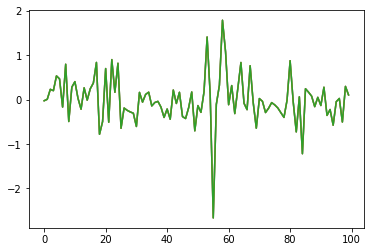

In [26]:
import matplotlib.pyplot as plt
print(embedding_matrix_no_ngram.shape)
plt.plot(embedding_matrix_no_ngram[16])
plt.show()

In [83]:

model = Sequential()
model.add(embedding_layer)
model.add(GlobalAveragePooling1D())
#model.add(Dropout(0.2))
#model.add(Conv1D(64, 5, activation='relu'))
#model.add(MaxPooling1D(pool_size=4))
#model.add(LSTM(100))
model.add(Dense(64, activation='relu'))
model.add(Dense(23, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [58]:
len(complete_train_no_ngram_padded)

85154

In [84]:
earlystopping_callback = EarlyStopping(monitor='val_loss', patience=2,restore_best_weights=True)
lr_reduce_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)        
model.fit(complete_train_no_ngram_padded,complete_labels_no_ngram
          ,batch_size = 32, validation_split=0.05, epochs = 7, callbacks = [earlystopping_callback,lr_reduce_callback])

Train on 101120 samples, validate on 5323 samples
Epoch 1/7
101120/101120 [==============================] - 107s 1ms/step - loss: 1.1855 - acc: 0.6783 - val_loss: 0.8698 - val_acc: 0.7468
Epoch 2/7
101120/101120 [==============================] - 98s 967us/step - loss: 0.7512 - acc: 0.7749 - val_loss: 0.7733 - val_acc: 0.7684
Epoch 3/7
101120/101120 [==============================] - 96s 945us/step - loss: 0.6199 - acc: 0.8079 - val_loss: 0.7369 - val_acc: 0.7796
Epoch 4/7
101120/101120 [==============================] - 96s 950us/step - loss: 0.5176 - acc: 0.8365 - val_loss: 0.7450 - val_acc: 0.7796
Epoch 5/7
101120/101120 [==============================] - 96s 946us/step - loss: 0.4275 - acc: 0.8646 - val_loss: 0.7556 - val_acc: 0.7774


In [107]:
no_ngram_cnn_pred7 = model.predict(complete_test_no_ngram_padded)
no_ngram_cnn_pred7 = list(map(np.argmax, no_ngram_cnn_pred7))
no_ngram_cnn_accu7 = accuracy_score (test_labels,no_ngram_cnn_pred7)
no_ngram_cnn_accu7

0.7627207816610296

#### Now training on complete data to find accuracy on test data

In [108]:
model2 = Sequential()
model2.add(embedding_layer)
model2.add(GlobalAveragePooling1D())
#model.add(Dropout(0.2))
#model.add(Conv1D(64, 5, activation='relu'))
#model.add(MaxPooling1D(pool_size=4))
#model.add(LSTM(100))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(23, activation='softmax'))
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#earlystopping_callback = EarlyStopping(monitor='val_loss', patience=2,restore_best_weights=True)
#lr_reduce_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)        
model2.fit(complete_train_no_ngram_padded,complete_labels_no_ngram
          ,batch_size = 32, epochs = 3)

Epoch 1/3
106443/106443 [==============================] - 69s 644us/step - loss: 0.6590 - acc: 0.8397
Epoch 2/3
106443/106443 [==============================] - 64s 599us/step - loss: 0.2596 - acc: 0.9302
Epoch 3/3
106443/106443 [==============================] - 70s 662us/step - loss: 0.1919 - acc: 0.9481


In [109]:
no_ngram_cnn_pred = model2.predict(complete_test_no_ngram_padded)
no_ngram_cnn_pred1 = list(map(np.argmax, no_ngram_cnn_pred))
no_ngram_cnn_accu = accuracy_score (test_labels,no_ngram_cnn_pred1)
no_ngram_cnn_accu

0.7218338970311913

### Now using data with ngram

In [85]:
#complete_data_ngram
#complete_labels_ngram


# Getting word embedding 
MAX_SEQUENCE_LENGTH = 130

tokenizer2 = Tokenizer()
tokenizer2.fit_on_texts(complete_data_ngram)

complete_train_ngram = tokenizer2.texts_to_sequences(complete_data_ngram)
complete_test_ngram = tokenizer2.texts_to_sequences(test_data_ngram)

word_index_ngram = tokenizer2.word_index
vocab_size = len(word_index_ngram)
max_words = vocab_size


print('Found %s unique words.' % len(word_index_ngram))

#padding the sequences
complete_train_ngram_padded = pad_sequences(complete_train_ngram, maxlen=MAX_SEQUENCE_LENGTH)
complete_test_ngram_padded = pad_sequences(complete_test_ngram, maxlen=MAX_SEQUENCE_LENGTH)
complete_labels_ngram = np.array(list(map(int, complete_labels_ngram)))
complete_labels_ngram = complete_labels_ngram - 1

#test_labels = np.array(list(map(int, test_labels)))
#test_labels = test_labels - 1

# Preparing embedding matrix 
EMBEDDING_DIM = glove_dict.get('a').shape[0]
num_words = max_words + 1
embedding_matrix_ngram = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index_ngram.items():
    if i>max_words:
        continue
    embedding_vector = glove_dict.get(word)
    if(embedding_vector is not None):
        embedding_matrix_ngram[i] = embedding_vector
        
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix_ngram),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True) # We set trainable to True because it gives better performance by optimizing the weights more




Found 40747 unique words.


In [86]:
model_ngram = Sequential()
model_ngram.add(embedding_layer)
model_ngram.add(GlobalAveragePooling1D())
#model.add(Dropout(0.2))
#model.add(Conv1D(64, 5, activation='relu'))
#model.add(MaxPooling1D(pool_size=4))
#model.add(LSTM(100))
model_ngram.add(Dense(64, activation='relu'))
model_ngram.add(Dense(23, activation='softmax'))
model_ngram.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [87]:

earlystopping_callback = EarlyStopping(monitor='val_loss', patience=2,restore_best_weights=True)

model_ngram.fit(complete_train_ngram_padded,complete_labels_ngram
          ,batch_size = 32, validation_split=0.05, epochs = 7, callbacks = [earlystopping_callback,lr_reduce_callback])

Train on 101120 samples, validate on 5323 samples
Epoch 1/7
101120/101120 [==============================] - 68s 674us/step - loss: 1.1924 - acc: 0.6772 - val_loss: 0.9022 - val_acc: 0.7338
Epoch 2/7
101120/101120 [==============================] - 60s 594us/step - loss: 0.7680 - acc: 0.7722 - val_loss: 0.8066 - val_acc: 0.7509
Epoch 3/7
101120/101120 [==============================] - 63s 627us/step - loss: 0.6437 - acc: 0.8017 - val_loss: 0.7817 - val_acc: 0.7642
Epoch 4/7
101120/101120 [==============================] - 63s 624us/step - loss: 0.5493 - acc: 0.8285 - val_loss: 0.7850 - val_acc: 0.7618
Epoch 5/7
101120/101120 [==============================] - 63s 621us/step - loss: 0.4684 - acc: 0.8526 - val_loss: 0.8012 - val_acc: 0.7659


In [110]:
ngram_cnn_pred7 = model_ngram.predict(complete_test_ngram_padded)
ngram_cnn_pred7 = list(map(np.argmax, ngram_cnn_pred7))
ngram_cnn_accu7 = accuracy_score (test_labels,ngram_cnn_pred7)
ngram_cnn_accu7

0.6874859075535513

### On test data

In [101]:
model_ngram2 = Sequential()
model_ngram2.add(embedding_layer)
model_ngram2.add(GlobalAveragePooling1D())
#model.add(Dropout(0.2))
#model.add(Conv1D(64, 5, activation='relu'))
#model.add(MaxPooling1D(pool_size=4))
#model.add(LSTM(100))
model_ngram2.add(Dense(64, activation='relu'))
model_ngram2.add(Dense(23, activation='softmax'))
model_ngram2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


model_ngram2.fit(complete_train_ngram_padded,complete_labels_ngram
          ,batch_size = 32, epochs = 3 )

Epoch 1/3
106443/106443 [==============================] - 66s 623us/step - loss: 0.9290 - acc: 0.7546
Epoch 2/3
106443/106443 [==============================] - 56s 523us/step - loss: 0.6166 - acc: 0.8153
Epoch 3/3
106443/106443 [==============================] - 57s 531us/step - loss: 0.5238 - acc: 0.8389


In [102]:
ngram_cnn_pred = model_ngram2.predict(complete_test_ngram_padded)
ngram_cnn_pred1 = list(map(np.argmax, ngram_cnn_pred))
ngram_cnn_accu = accuracy_score (test_labels,ngram_cnn_pred1)
ngram_cnn_accu

0.7585494175122135

In [105]:
model_ngram5 = Sequential()
model_ngram5.add(embedding_layer)
model_ngram5.add(GlobalAveragePooling1D())
#model.add(Dropout(0.2))
#model.add(Conv1D(64, 5, activation='relu'))
#model.add(MaxPooling1D(pool_size=4))
#model.add(LSTM(100))
model_ngram5.add(Dense(64, activation='relu'))
model_ngram5.add(Dense(23, activation='softmax'))
model_ngram5.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


model_ngram5.fit(complete_train_ngram_padded,complete_labels_ngram
          ,batch_size = 32, epochs = 5 )

Epoch 1/5
106443/106443 [==============================] - 69s 650us/step - loss: 0.8009 - acc: 0.7936
Epoch 2/5
106443/106443 [==============================] - 63s 596us/step - loss: 0.5013 - acc: 0.8505
Epoch 3/5
106443/106443 [==============================] - 65s 608us/step - loss: 0.4220 - acc: 0.8721
Epoch 4/5
106443/106443 [==============================] - 65s 612us/step - loss: 0.3591 - acc: 0.8896
Epoch 5/5
106443/106443 [==============================] - 64s 602us/step - loss: 0.3062 - acc: 0.9062


In [106]:
ngram_cnn_pred5 = model_ngram5.predict(complete_test_ngram_padded)
ngram_cnn_pred5 = list(map(np.argmax, ngram_cnn_pred5))
ngram_cnn_accu5 = accuracy_score (test_labels,ngram_cnn_pred5)
ngram_cnn_accu5

0.7447576099210823

In [ ]:
kernel_size = 5
filters = 64
pool_size = 4

lstm_output_size = 70

model_lstm_cnn <- keras_model_sequential()

model_lstm_cnn %>% 
    layer_embedding(input_dim = vocab_size, input_length = maxlen,output_dim = embedding_size) %>%
    layer_dropout(0.25) %>%
    layer_conv_1d(
       filters, 
       kernel_size, 
       padding = "valid",
       activation = "relu",
       strides = 1
    ) %>%
  layer_max_pooling_1d(pool_size) %>%
  layer_lstm(units= maxlen+50)%>%
  layer_dense(units = 23, activation = "softmax")


get_layer(model_lstm_cnn, index = 1) %>% 
  set_weights(list(embedding_matrix)) #%>% 
  #freeze_weights()

model_lstm_cnn %>% summary()
# len
model_lstm_cnn %>% compile(
  loss = "sparse_categorical_crossentropy",
  optimizer = "adam",
  metrics = "accuracy"
)

history_lstm_cnn <- model_lstm_cnn %>% fit(
  train_data_ass,
  complete_labels_for_cnn_n_lstm,
  epochs =3,
  batch_size = 32,
  #validation_split=0.3,
  validation_data = list(val_data_ass, y_val4),
  verbose=1,
  callbacks = list(
  callback_model_checkpoint("checkpoints_cnn_lstm_zongz.h5", monitor = "val_acc", verbose = 0,
  save_best_only = TRUE, save_weights_only = FALSE, mode = "max", period = 1),
  callback_reduce_lr_on_plateau(monitor = "val_loss", factor = 0.1)
  )
)

### As we can see from above experiments.... the test accuracy varies a lot.

### Lets try with CNN + LSTM model

In [115]:
kernel_size = 5
filters = 64
pool_size = 4

lstm_output_size = 70


model_ngram_cnnlstm = Sequential()
model_ngram_cnnlstm.add(embedding_layer)
model_ngram_cnnlstm.add(Dropout(0.2))
model_ngram_cnnlstm.add(Conv1D(64, 5, activation='relu'))
model_ngram_cnnlstm.add(MaxPooling1D(pool_size=4))
model_ngram_cnnlstm.add(LSTM(180))
model_ngram_cnnlstm.add(Dense(64, activation='relu'))
model_ngram_cnnlstm.add(Dense(23, activation='softmax'))
model_ngram_cnnlstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


model_ngram_cnnlstm.fit(complete_train_ngram_padded,complete_labels_ngram
          ,batch_size = 32, epochs = 3 )

Epoch 1/3
106443/106443 [==============================] - 685s 6ms/step - loss: 0.6083 - acc: 0.8129
Epoch 2/3
106443/106443 [==============================] - 669s 6ms/step - loss: 0.4329 - acc: 0.8634
Epoch 3/3
106443/106443 [==============================] - 668s 6ms/step - loss: 0.3733 - acc: 0.8811


In [112]:
complete_train_ngram_padded.shape

(106443, 130)

In [117]:
ngram_cnnlstm_pred = model_ngram_cnnlstm.predict(complete_test_ngram_padded)
ngram_cnnlstm_pred = list(map(np.argmax, ngram_cnnlstm_pred))
ngram_cnnlstm_accu = accuracy_score (test_labels,ngram_cnnlstm_pred)
ngram_cnnlstm_accu

0.7311161217587373

### CNN+ LSTM with different configuration

In [118]:
kernel_size = 5
filters = 64
pool_size = 4

lstm_output_size = 70


model_ngram_cnnlstm1 = Sequential()
model_ngram_cnnlstm1.add(embedding_layer)
#model_ngram_cnnlstm.add(Dropout(0.2))
model_ngram_cnnlstm1.add(Conv1D(64, 5, activation='relu'))
model_ngram_cnnlstm1.add(MaxPooling1D(pool_size=4))
model_ngram_cnnlstm1.add(LSTM(150))
model_ngram_cnnlstm1.add(Dense(23, activation='softmax'))
model_ngram_cnnlstm1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


model_ngram_cnnlstm1.fit(complete_train_ngram_padded,complete_labels_ngram
          ,batch_size = 32, validation_split=0.03, epochs = 5, callbacks = [earlystopping_callback])

Train on 103249 samples, validate on 3194 samples
Epoch 1/5
103249/103249 [==============================] - 245s 2ms/step - loss: 0.5124 - acc: 0.8435 - val_loss: 0.4518 - val_acc: 0.8591
Epoch 2/5
103249/103249 [==============================] - 393s 4ms/step - loss: 0.3369 - acc: 0.8970 - val_loss: 0.4764 - val_acc: 0.8547
Epoch 3/5
103249/103249 [==============================] - 621s 6ms/step - loss: 0.2670 - acc: 0.9171 - val_loss: 0.4835 - val_acc: 0.8594


In [119]:
ngram_cnnlstm_pred1 = model_ngram_cnnlstm1.predict(complete_test_ngram_padded)
ngram_cnnlstm_pred1 = list(map(np.argmax, ngram_cnnlstm_pred1))
ngram_cnnlstm_accu1 = accuracy_score (test_labels,ngram_cnnlstm_pred1)
ngram_cnnlstm_accu1

0.7282600526118

### CNN+ LSTM without ngrams

In [120]:
kernel_size = 5
filters = 64
pool_size = 4

lstm_output_size = 70


model_no_ngram_cnnlstm = Sequential()
model_no_ngram_cnnlstm.add(embedding_layer)
#model_ngram_cnnlstm.add(GlobalAveragePooling1D())
#model_ngram_cnnlstm.add(Dropout(0.2))
model_no_ngram_cnnlstm.add(Conv1D(64, 5, activation='relu'))
model_no_ngram_cnnlstm.add(MaxPooling1D(pool_size=4))
model_no_ngram_cnnlstm.add(LSTM(150))
model_no_ngram_cnnlstm.add(Dense(23, activation='softmax'))
model_no_ngram_cnnlstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


model_no_ngram_cnnlstm.fit(complete_train_no_ngram_padded,complete_labels_no_ngram
          ,batch_size = 32, validation_split=0.03, epochs = 5, callbacks = [earlystopping_callback])

Train on 103249 samples, validate on 3194 samples
Epoch 1/5
103249/103249 [==============================] - 548s 5ms/step - loss: 0.4627 - acc: 0.8591 - val_loss: 0.3006 - val_acc: 0.9020
Epoch 2/5
103249/103249 [==============================] - 561s 5ms/step - loss: 0.2704 - acc: 0.9160 - val_loss: 0.3117 - val_acc: 0.9029
Epoch 3/5
103249/103249 [==============================] - 609s 6ms/step - loss: 0.2061 - acc: 0.9370 - val_loss: 0.3235 - val_acc: 0.8998


In [122]:
no_ngram_cnnlstm_pred = model_no_ngram_cnnlstm.predict(complete_test_no_ngram_padded)
no_ngram_cnnlstm_pred = list(map(np.argmax, no_ngram_cnnlstm_pred))
no_ngram_cnnlstm_accu = accuracy_score (test_labels,no_ngram_cnnlstm_pred)
no_ngram_cnnlstm_accu

0.7055993987222848

#### with dropout and another dense layer

In [124]:
kernel_size = 5
filters = 64
pool_size = 4

lstm_output_size = 70


model_no_ngram_cnnlstm2 = Sequential()
model_no_ngram_cnnlstm2.add(embedding_layer)
#model_ngram_cnnlstm.add(GlobalAveragePooling1D())
model_no_ngram_cnnlstm2.add(Dropout(0.2))
model_no_ngram_cnnlstm2.add(Conv1D(64, 5, activation='relu'))
model_no_ngram_cnnlstm2.add(MaxPooling1D(pool_size=4))
model_no_ngram_cnnlstm2.add(LSTM(150))
model_no_ngram_cnnlstm2.add(Dense(64, activation='relu'))
model_no_ngram_cnnlstm2.add(Dense(23, activation='softmax'))
model_no_ngram_cnnlstm2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


model_no_ngram_cnnlstm2.fit(complete_train_no_ngram_padded,complete_labels_no_ngram
          ,batch_size = 32, validation_split=0.03, epochs = 3, callbacks = [earlystopping_callback])

Train on 103249 samples, validate on 3194 samples
Epoch 1/3
103249/103249 [==============================] - 582s 6ms/step - loss: 0.5048 - acc: 0.8437 - val_loss: 0.3575 - val_acc: 0.8860
Epoch 2/3
103249/103249 [==============================] - 612s 6ms/step - loss: 0.3158 - acc: 0.9005 - val_loss: 0.3441 - val_acc: 0.8929
Epoch 3/3
103249/103249 [==============================] - 658s 6ms/step - loss: 0.2722 - acc: 0.9147 - val_loss: 0.3464 - val_acc: 0.8914


In [125]:
no_ngram_cnnlstm_pred2 = model_no_ngram_cnnlstm2.predict(complete_test_no_ngram_padded)
no_ngram_cnnlstm_pred2 = list(map(np.argmax, no_ngram_cnnlstm_pred2))
no_ngram_cnnlstm_accu2 = accuracy_score (test_labels,no_ngram_cnnlstm_pred2)
no_ngram_cnnlstm_accu2

0.7092446448703494

### Just to observe if results vary if i change the validation split by increasing it to 10%. Even though the training set used to train the data will decrease but will it have any counter intuitive result?

In [126]:
kernel_size = 5
filters = 64
pool_size = 4

lstm_output_size = 70


model_no_ngram_cnnlstm3 = Sequential()
model_no_ngram_cnnlstm3.add(embedding_layer)
#model_ngram_cnnlstm.add(GlobalAveragePooling1D())
model_no_ngram_cnnlstm3.add(Dropout(0.2))
model_no_ngram_cnnlstm3.add(Conv1D(64, 5, activation='relu'))
model_no_ngram_cnnlstm3.add(MaxPooling1D(pool_size=4))
model_no_ngram_cnnlstm3.add(LSTM(150))
model_no_ngram_cnnlstm3.add(Dense(64, activation='relu'))
model_no_ngram_cnnlstm3.add(Dense(23, activation='softmax'))
model_no_ngram_cnnlstm3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


model_no_ngram_cnnlstm3.fit(complete_train_no_ngram_padded,complete_labels_no_ngram
          ,batch_size = 32, validation_split=0.1, epochs = 3, callbacks = [earlystopping_callback])

Train on 95798 samples, validate on 10645 samples
Epoch 1/3
95798/95798 [==============================] - 613s 6ms/step - loss: 0.4884 - acc: 0.8518 - val_loss: 0.3401 - val_acc: 0.8959
Epoch 2/3
95798/95798 [==============================] - 618s 6ms/step - loss: 0.2875 - acc: 0.9107 - val_loss: 0.3331 - val_acc: 0.8959
Epoch 3/3
95798/95798 [==============================] - 589s 6ms/step - loss: 0.2419 - acc: 0.9248 - val_loss: 0.3397 - val_acc: 0.8988


In [127]:
no_ngram_cnnlstm_pred3 = model_no_ngram_cnnlstm3.predict(complete_test_no_ngram_padded)
no_ngram_cnnlstm_pred3 = list(map(np.argmax, no_ngram_cnnlstm_pred3))
no_ngram_cnnlstm_accu3 = accuracy_score (test_labels,no_ngram_cnnlstm_pred3)
no_ngram_cnnlstm_accu3

0.7101841413002631

## CNN+ LSTM Summary
### From above tests we can notice that the best accuracy was in the first attempt with ngrams using the complete dataset as training data
==========================================================================================================

## Fast text model 
==========================
### A model developed by Facebook which can be used for text classification
#### It can be installed from https://github.com/facebookresearch/fastText/tree/master/python

First we will transform the input into required format. Each document is required to be preceded by \_\_label\_\_[label] and a space.
 Example : \_\_label_\_19 year_man ballarat hospital minor_injury crash tree maryborough crash midnight intersection timor road police_investigate cause collision

Since ngrams can be specified in fasttext api we will use data without ngrams initially.

In [13]:
# taking the complete data and labels and concatenating them as required by API
# Adding __label__ to each string in labels list
training_labels_fastext_no_ngram = ['__label__'+str(a)+' ' for a in complete_labels_no_ngram]
traindata_with_labels_fastext_no_ngram = ["{}{}".format(labels_,docs_) for  labels_,docs_ in zip(training_labels_fastext_no_ngram,complete_data_no_ngram)]
# Doing same for test data without ngram
testing_labels_fastext = ['__label__'+str(a)+' ' for a in test_labels]
testdata_with_labels_fastext_no_ngram = ["{}{}".format(labels_,docs_) for  labels_,docs_ in zip(testing_labels_fastext,test_data_no_ngram)]


# we can also do the same with data with ngram just for testing purposes for later modelling
training_labels_fastext_ngram = ['__label__'+str(a)+' ' for a in complete_labels_ngram]
traindata_with_labels_fastext_ngram = ["{}{}".format(labels_,docs_) for  labels_,docs_ in zip(training_labels_fastext_ngram,complete_data_ngram)]

# Doing same for test data with ngram
testdata_with_labels_fastext_ngram = ["{}{}".format(labels_,docs_) for  labels_,docs_ in zip(testing_labels_fastext,test_data_ngram)]


In [14]:
# Writing to disk since the input for fast text model accepts a filepath
with open('traindata_with_labels_fastext_no_ngram.txt','w+') as o_fh:
    for doc in traindata_with_labels_fastext_no_ngram:
        o_fh.write('{}'.format(doc))
            
        o_fh.write('\n')
o_fh.close()                
 
    
with open('testdata_with_labels_fastext_no_ngram.txt','w+') as o_fh:
    for doc in testdata_with_labels_fastext_no_ngram:
        o_fh.write('{}'.format(doc))
            
        o_fh.write('\n')
o_fh.close()                

with open('traindata_with_labels_fastext_ngram.txt','w+') as o_fh:
    for doc in traindata_with_labels_fastext_ngram:
        o_fh.write('{}'.format(doc))
            
        o_fh.write('\n')
o_fh.close()                

with open('testdata_with_labels_fastext_ngram.txt','w+') as o_fh:
    for doc in testdata_with_labels_fastext_ngram:
        o_fh.write('{}'.format(doc))
            
        o_fh.write('\n')
o_fh.close()                


In [15]:

# From previous testing we already have optimal parameters for this corpus
# to make a model so we will directly be checking accuracy on test data
def print_results(N, p, r):
    print("N\t" + str(N))
    print("P@{}\t{:.3f}".format(1, p))
    print("R@{}\t{:.3f}".format(1, r))
model = train_supervised(input = 'traindata_with_labels_fastext_no_ngram.txt',lr=0.8,dim=50,epoch=25,minCount=1,wordNgrams=3,loss="softmax",verbose=2,thread = 3)

In [17]:
print_results(*model.test('testdata_with_labels_fastext_no_ngram.txt'))

N	26134
P@1	0.777
R@1	0.777


In [21]:
pred_fastext = model.predict(testdata_with_labels_fastext_no_ngram)

In [70]:

result = [re.search(r'.+__(\d+)',x[0]).group(1) for x in pred_fastext[0]]

In [72]:
fastest_no_ngram_accu = accuracy_score (test_labels,result)
fastest_no_ngram_accu

0.7635099586621571

In [73]:
## model for fastext using data with ngram

model_ngram = train_supervised(input = 'traindata_with_labels_fastext_ngram.txt',lr=0.8,dim=50,epoch=25,minCount=1,wordNgrams=3,loss="softmax",verbose=2,thread = 3)
print_results(*model_ngram.test('testdata_with_labels_fastext_ngram.txt'))
pred_fastext_ngram = model_ngram.predict(testdata_with_labels_fastext_ngram)
result_ngram = [re.search(r'.+__(\d+)',x[0]).group(1) for x in pred_fastext_ngram[0]]
fastest_ngram_accu = accuracy_score (test_labels,result_ngram)
print('fastest_ngram_accu=',fastest_ngram_accu)

N	26134
P@1	0.776
R@1	0.776
fastest_ngram_accu= 0.762532882375047


# Summary:
## Overall it seems that MLP has the highest accuracy among all the algorithms tested above.